# Lab Assignment Five: Wide & Deep Network Architectures

## Team Members
1. Piyush Metkar  - 47509180
2. Rishab Vaishya - 47505527
3. Dhaval Gogri   - 47444609

# BUSINESS UNDERSTANDING

Reference : https://www.kaggle.com/mlsyn91/deep-learning-a-z-ann-dataset/data

This dataset is taken from Kaggle and it is about the customers of a bank and whether they exit the bank or not along with other factors such as tenure - number of years the customer has an account in the bank, balance - the amount of cash the customer has deposited in the bank, number of products - The various products/services a customer is using of the bank, has credit card - Whether the customer is using a bank credit card for purchases or not, isActive member - If the customer is an active member of the bank or not I.e. using bank services regularly, estimated salary - The amount he earns from work and how much does he deposit in the bank. 
This dataset has approximate 10000 values which is good enough for a deep learning model. 

The main aim of this project is to predict the potential customers who would close their account and leave the bank to join their competitor. If we observe the dataset around **20%** of customers are leaving the bank which is a very high percentage. By using this data, the bank can use this learning model to predict and retain its customers. They can introduce new products or services by taking feedback from customers and make them offers such as reducing the interest rate on credit card or waiving off one late payment on credit card bill so that their credit score is not affected. The bank can try to improve the customer relation and increase their involvement. They can also provide higher interest rates on savings accounts so as to bind the customer and their **loyalty** to the bank.

By retaining more customer this would also help the bank to improve their reputation and increase their customer base. As the saying goes ‘The customers are your best marketing people’.  The more you keep your customers happy, the more your customer base increases.

A realistic and viable target for the model would be **80%**. If we can correctly identify atleast 80% of the customers who are most likely to leave the bank and can convince atleast half of them to stay, we are looking at safeguarding atleast 90% of the total valuable customers.


# 1. DATA PREPARATION

## 1.1Dataset Cleaning

In [117]:
import pandas as pd
import numpy as np

import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn import metrics as mt
from imblearn.over_sampling import SMOTE

from copy import deepcopy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Merge, concatenate, Dropout
from keras.models import Model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [118]:
df = pd.read_csv('file:///Users/piyushmetkar/Documents/SMU/Notes/Spring 18/7324 Machine Learning in Python/Lab 5/Churn_Modelling1.csv')
# df = pd.read_csv('file:///Users/dhavalgogri/Downloads/Churn_Modelling.csv')

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,8428,15806771,Yefremova,753,France,Female,40,0,3768.69,2,1,0,177065.24,1
1,5687,15713774,Chikwendu,644,Spain,Female,46,6,12459.19,1,0,0,156787.34,1
2,1792,15776467,De Salis,702,Spain,Female,35,8,14262.80,2,1,0,54689.16,0
3,5049,15741416,Yegorov,707,France,Male,42,2,16893.59,1,1,1,77502.56,0
4,6030,15669011,Bocharova,659,France,Female,44,9,23503.31,1,0,1,169862.01,1


Here the columns RowNumber, CustomerId and Surname are useless for our prediction model. Hence we drop them from the dataframe.

Age of the customers is recorded as continuous integer type. We categorize the age group as follows
- 0 to 20
- 21 to 35
- 36 to 50
- 51 to 70
- 70 above

The above age groups will help us to find if there exists any pattern of customers leaving.

Let's one hot encode the categorical features Age, Gender and Geography.

In [119]:
df_copy = deepcopy(df)
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df['Age'] = pd.cut(x=df['Age'],bins=[0, 20, 35, 50, 70, 150],labels=['0-20','21-35','36-50','51-70', '70 above'])

In [120]:

# columns = df.columns.values

# sm = SMOTE(random_state=12, ratio = 1)
# X_bal, y_bal = sm.fit_sample(df.iloc[:, 0:10].values, df['Exited'].values)

In [121]:
categorical_headers = ['Geography','Gender','Age']
numeric_headers = ['CreditScore', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
encoders = dict() 

df_train = df.sample(frac=0.8,random_state=200)
df_test = df.drop(df_train.index)

for col in categorical_headers:
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()
    
    encoders[col] = LabelEncoder()
    df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
    df_test[col+'_int'] = encoders[col].transform(df_test[col])
    
for col in numeric_headers:
    df_train[col] = df_train[col].astype(np.int)
    df_test[col] = df_test[col].astype(np.int)
    
    df_train[col] = df_train[col].values.reshape(-1, 1)
    df_test[col] = df_test[col].values.reshape(-1, 1)

In [122]:

categorical_headers_ints = [x+'_int' for x in categorical_headers]
feature_columns = categorical_headers_ints+numeric_headers

sm = SMOTE(random_state=12, ratio = 1)
X_train_bal, y_train_bal = sm.fit_sample(df_train[feature_columns].values, df_train['Exited'].values)
X_test_bal, y_test_bal = sm.fit_sample(df_test[feature_columns].values, df_test['Exited'].values)


y_train_bal = y_train_bal.reshape((y_train_bal.shape[0],1))
y_test_bal = y_test_bal.reshape((y_test_bal.shape[0],1))


nparr1 = np.hstack((X_train_bal, y_train_bal))
nparr2 = np.hstack((X_test_bal, y_test_bal))

nparr3 = np.vstack((nparr1, nparr2))
df_bal = pd.DataFrame(nparr3, columns=feature_columns + ['Exited'])

df_train = df_bal.sample(frac=0.8,random_state=200)
df_test = df_bal.drop(df_train.index)

X_train =  df_train[feature_columns].values
X_test =  df_test[feature_columns].values

y_train = df_train['Exited'].values.astype(int)
y_test = df_test['Exited'].values.astype(int)

print(np.sum(y_train), '/', y_train.shape[0])
print(np.sum(y_test), '/', y_test.shape[0])

print(feature_columns)

3857 / 7754
989 / 1938
['Geography_int', 'Gender_int', 'Age_int', 'CreditScore', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [123]:
# df_test.round(int)
df_test['NumOfProducts'] = df_test['NumOfProducts'].values.round().astype(int)
df_test['Geography_int'] = df_test['Geography_int'].values.round().astype(int)
df_test['Gender_int'] = df_test['Gender_int'].values.round().astype(int)
df_test['Age_int'] = df_test['Age_int'].values.round().astype(int)
df_test['CreditScore'] = df_test['CreditScore'].values.round().astype(int)
df_test['Tenure'] = df_test['Tenure'].values.round().astype(int)
df_test['Balance'] = df_test['Balance'].values.round().astype(int)
df_test['HasCrCard'] = df_test['HasCrCard'].values.round().astype(int)
df_test['IsActiveMember'] = df_test['IsActiveMember'].values.round().astype(int)
df_test['EstimatedSalary'] = df_test['EstimatedSalary'].values.round().astype(int)
df_test['Exited'] = df_test['Exited'].values.round().astype(int)


df_train['NumOfProducts'] = df_train['NumOfProducts'].values.round().astype(int)
df_train['Geography_int'] = df_train['Geography_int'].values.round().astype(int)
df_train['Gender_int'] = df_train['Gender_int'].values.round().astype(int)
df_train['Age_int'] = df_train['Age_int'].values.round().astype(int)
df_train['CreditScore'] = df_train['CreditScore'].values.round().astype(int)
df_train['Tenure'] = df_train['Tenure'].values.round().astype(int)
df_train['Balance'] = df_train['Balance'].values.round().astype(int)
df_train['HasCrCard'] = df_train['HasCrCard'].values.round().astype(int)
df_train['IsActiveMember'] = df_train['IsActiveMember'].values.round().astype(int)
df_train['EstimatedSalary'] = df_train['EstimatedSalary'].values.round().astype(int)
df_train['Exited'] = df_train['Exited'].values.round().astype(int)

# df_test.NumOfProducts.round()
# df_test.HasCrCard.round()


In [124]:
encoder_ohe = OneHotEncoder()

X_train_ohe = encoder_ohe.fit_transform(df_train[categorical_headers_ints].values)
X_test_ohe = encoder_ohe.transform(df_test[categorical_headers_ints].values)

print(encoder_ohe.feature_indices_)
print(X_train_ohe.shape)
print(type(X_train_ohe), '========THIS IS SPARSE ENCODED=======')


[ 0  3  5 10]
(7754, 10)
<class 'scipy.sparse.csr.csr_matrix'> ========THIS IS SPARSE ENCODED=======


Our final dataset contains 10 features and a binary target class as above. The categorical features have been one hot encoded. We dropped 3 redundant columns from original dataset. 

Since all the features are necessary and carry an equal weight in predicting the target class, we don't need to perform any sort of dimensionality reduction technique on the dataset.

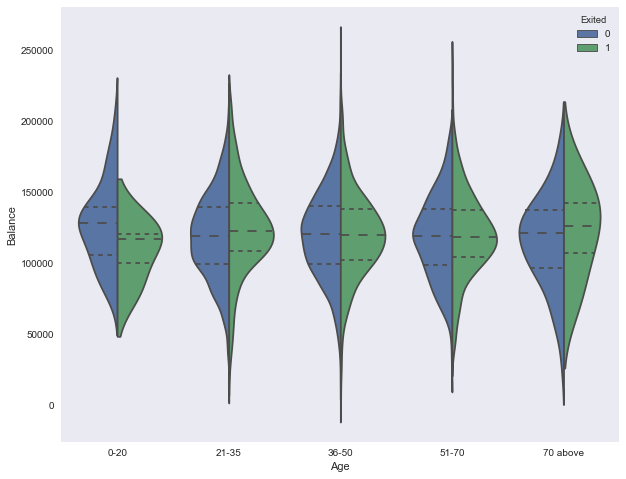

In [125]:
rcParams['figure.figsize'] = 10, 8

sns.violinplot(data=df, x='Age', y='Balance', hue='Exited', split=True, inner='quart')
plt.show()

Above is a violin plot between Age and Balance they have in their bank and who has exited or not exited the bank later on. From the graph we can observe that customers with in the age range of 0-20 & 70 above are the ones who left the bank the most. Also its worth noting that that the mean balance in these groups is also low compared to others.

Text(0.5,1,'Correlation Matrix Graph')

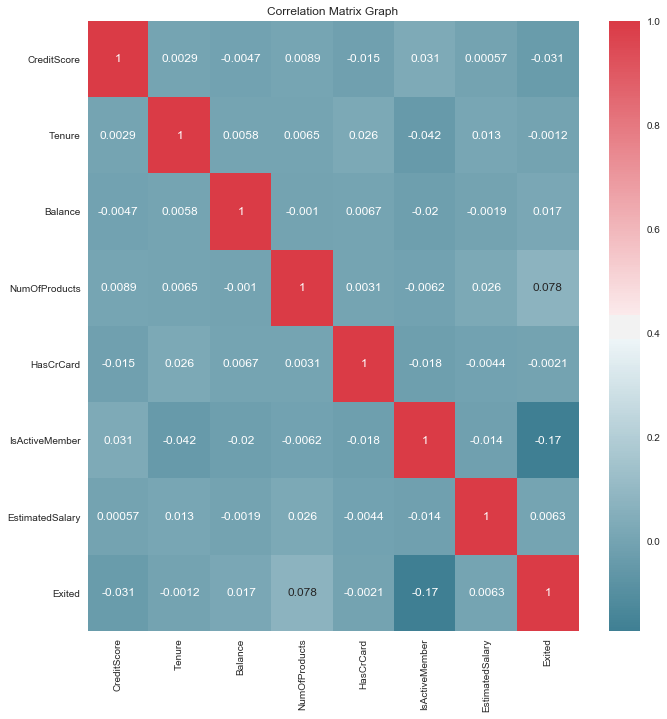

In [126]:
dfhmp = df[['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']].copy()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(dfhmp.corr(), cmap=cmap, annot=True)

f.tight_layout()
plt.title('Correlation Matrix Graph')

From the above Corelation graph we can find a strong relation between isActiveMember and Exited. They are inversely related to each other. i.e. if a customer is more active, he would not leave the bank and vice-versa. 

If we also look at other relations, we can find out that for example we take Tenure-Exited. Other examples include Balance-Exited, NumOfProducts-Balance, etc. We can make use of these combinations to extract more learning from the model.

## 1.2 Cross-Product Features

In our dataset we can use a combination of features to get the best result out of it. Some of those cross features can be like
- Age, Gender and isActiveMember - With age the use of bank services for personal and corporate use my change. Also the gender plays a big role in bank services usage. 

- isActivemember, Tenure -

- Geography, Gender, Age -

In [127]:
cross_columns = [['Age_int','Gender_int', 'IsActiveMember'],
                 ['IsActiveMember', 'Tenure'],
                 ['Geography_int', 'Gender_int', 'Age_int']]
#cross_columns = [['IsActiveMember', 'Tenure']]

## 1.3 Evaluation Metric


The business case for this model forms with the aim to correctly predict the customers who are about to or will leave the bank for their competitors. So implicitly it means that it is important for model to get high percentage of true positive.

Also we need to reduce the number of False Negatives as for our business case a false negative simply means a customer who will leave but our model failed to identify so and thus take appropriate actions in order to keep the customer.

By considering above to use cases, **recall** fits to be the best evaluation criteria for our model.

**Note:** We are not considering false positive to evaluate to performance of our model because higher or lower false positives will not hurt the bank. A false positive is the case when customer doesn't want to leave the bank but is predicted to leave. Hence the bank will pay more attention towards this customer in aspiration to retain him and there by indirectly making sure that it remains loyal to the bank. So higher number of false positive is actually a win-win situation for both the parties.

## 1.4 Cross Validation Technique

ANN dataset has **20%** positive records and **80%** negative records. Thus there is high unequal distribution of data across the two classes. In such case we can't use the simple K-Fold cross validation as this technique sequentially divides the data into K folds. If we have a high concentration of positive records in a region, that will increase the percentage of positive records for that fold and decrease in other folds and thus the model will not be trained consistently.

In order to evenly distribute the target classes, we will be using **stratified shuffle split**. This will make sure that each fold gets consistent percentage of both positive and negative classes.

In [128]:

#X = df.iloc[:, 0:10].values
#y = df['Exited'].values

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

#for train_index, test_index in sss.split(X, y):
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]

class_names = ['Not exited', 'Exited']

In [129]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:8
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [130]:
rcParams['figure.figsize'] = 4, 4
rcParams['axes.grid'] = False
#plot_confusion_matrix(mt.confusion_matrix(y_test,yhat2), classes=class_names, normalize=False, title='Confusion matrix', cmap=plt.cm.PuBu)

In [131]:
# and save off the numeric features
X_train_num =  df_train[numeric_headers].values
X_test_num = df_test[numeric_headers].values

# Multi-Modal Networks: Combine Branches, Sparse and Dense¶

Lets create different network models in the following steps, We've decided to build 3 different models. They are various combinations of wide and deep networks. We would be creating it and analysing the perofrmance of them.
Each network has been explained step wise below.

## Deep & Wide N/W 1 - Without Dropout

## Step 1 - Making Cross columns layer

1. here we use a single dense layer network with their inputs being flattened crossed categorical features columns.
2. Embeddings are made for the same. 
3. A total of 3 crossed categorical data used here which are  
 - Age, Gender & IsActiveMember
 - IsActiveMember & Tenure
 - Geography, Gender & Age
 4.  the concatinated layers is then passed through a single dense fitting layer. 
 5. All the 3 crossed categorical data are passed simulatinously in the dense layer here.
 6. this is done so that the model remembers the pairs and predict if same pairs occurs again in the future..

## Step 2 - creating generalized model

1. Here we use our Numerical and one-hot encoded features mentioned above & create a deep network model
2. The numerical data are is passed through a single dense layer while the one-hot encoded features are embedded and flattened just like the cross categorical datas.
3. bothe types of data are concatinated and passed through a single layer dense fitting.
4. This is then passed through a drop out to prevent over fitting of the data.
5. This is used to get the generalized performance of the model

## Step 3 - concatinating the above 2 networks

1.  Finally the network we got from step 1 & step 2, we concatinate them.
2. the combined network are once again passed through single dense layer for fitting. t=This is done to make the model both memorize the frequenlty related & dependable pairs and also for general use.

Model 1 can be visualised graphically below.

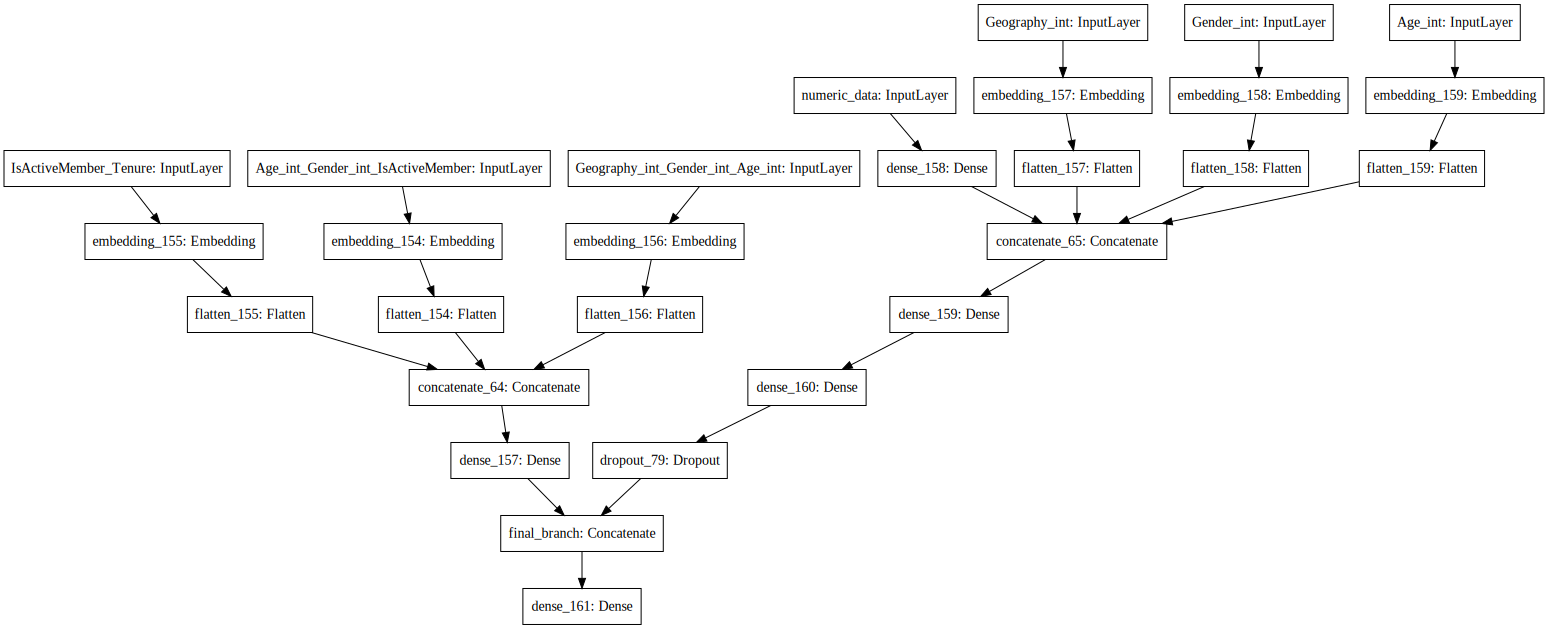

In [144]:
#ref: https://github.com/eclarson/MachineLearningNotebooks/blob/master/10.%20Keras%20Wide%20and%20Deep.ipynb

# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_branch_outputs = []

for cols in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(str(v) for v in x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(str(v) for v in x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_branch_outputs)
wide_branch = Dense(units=20, activation='relu')(wide_branch)

# reset this input branch
all_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False,name='numeric_data'))
x = Dense(units=20, activation='relu')(all_inputs[-1])
all_branch_outputs.append( x )

# merge the branches together
deep_branch = concatenate(all_branch_outputs)
deep_branch = Dense(units=50,activation='relu')(deep_branch)
deep_branch = Dense(units=10,activation='relu')(deep_branch)
deep_branch = Dropout(rate=0.1)(deep_branch)

final_branch = concatenate([wide_branch, deep_branch], name='final_branch')
final_branch = Dense(units=1,activation='sigmoid')(final_branch)


model1 = Model(inputs=all_inputs, outputs=final_branch)
SVG(model_to_dot(model1).create(prog='dot', format='svg'))

In [145]:
from sklearn.utils import class_weight
class_weight1 = {0:1,1:100}
class_weight = compute_sample_weight(class_weight1, y_train)
model1.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])

model1.fit(X_ints_train+ [X_train_num], y_train, epochs=10, batch_size=32, verbose=1, class_weight = class_weight)

yhat1 = np.round(model1.predict(X_ints_test + [X_test_num]))
print(mt.confusion_matrix(y_test,yhat1),mt.accuracy_score(y_test,yhat1))

Epoch 1/10
7754/7754 [==============================] - 3s 417us/step - loss: 0.5041 - acc: 0.4954
Epoch 2/10
7754/7754 [==============================] - 1s 78us/step - loss: 0.5016 - acc: 0.4985
Epoch 3/10
7754/7754 [==============================] - 1s 77us/step - loss: 0.5069 - acc: 0.4925
Epoch 4/10
7754/7754 [==============================] - 1s 78us/step - loss: 0.5048 - acc: 0.4950
Epoch 5/10
7754/7754 [==============================] - 1s 77us/step - loss: 0.5099 - acc: 0.4902
Epoch 6/10
7754/7754 [==============================] - 1s 78us/step - loss: 0.5034 - acc: 0.4966
Epoch 7/10
7754/7754 [==============================] - 1s 78us/step - loss: 0.5015 - acc: 0.4983
Epoch 8/10
7754/7754 [==============================] - 1s 78us/step - loss: 0.5053 - acc: 0.4947
Epoch 9/10
7754/7754 [==============================] - 1s 85us/step - loss: 0.5018 - acc: 0.4978
Epoch 10/10
7754/7754 [==============================] - 1s 83us/step - loss: 0.5054 - acc: 0.4947
[[247 702]
 [246 7

## Deep & Wide N/W 2 with Dropout

Ref: https://www.tensorflow.org/api_docs/python/tf/layers/dropout

## Step 1 - Making Cross columns

1. Here changed the model a little compared to step 1 of model 1.
2. we concatinate the cross categorical features first and then pass it through the layers to fit.
3. A total of 3 crossed categorical data used here which are  
 - Age, Gender & IsActiveMember
 - IsActiveMember & Tenure
 - Geography, Gender & Age
 4. these branch of datas are concatinated & passed through the 2 dense fitting layer followed by dropouts so that the model doesn't over fit.

## Step 2 - Using Deep Embeddings

1. Here we use our Numerical and one-hot encoded features mentioned above for creating the network model
2. The numerical data are is passed through a single dense layer while the one-hot encoded features remains unchanged.
3. bothe types of data are concatinated and passed through 2 layer dense fitting followed by dropouts so that the model doesn't over fit just like step 1.
4. This is used to get the generalized performance of the model

## Step 3 - concatinating the above 2 networks

1.  Finally the network we got from step 1 & step 2, we concatinate them.
2. the combined network are once again passed through single dense layer for fitting. t=This is done to make the model both memorize the frequenlty related & dependable pairs and also for general use.

Model 2 can be visualised graphically below.

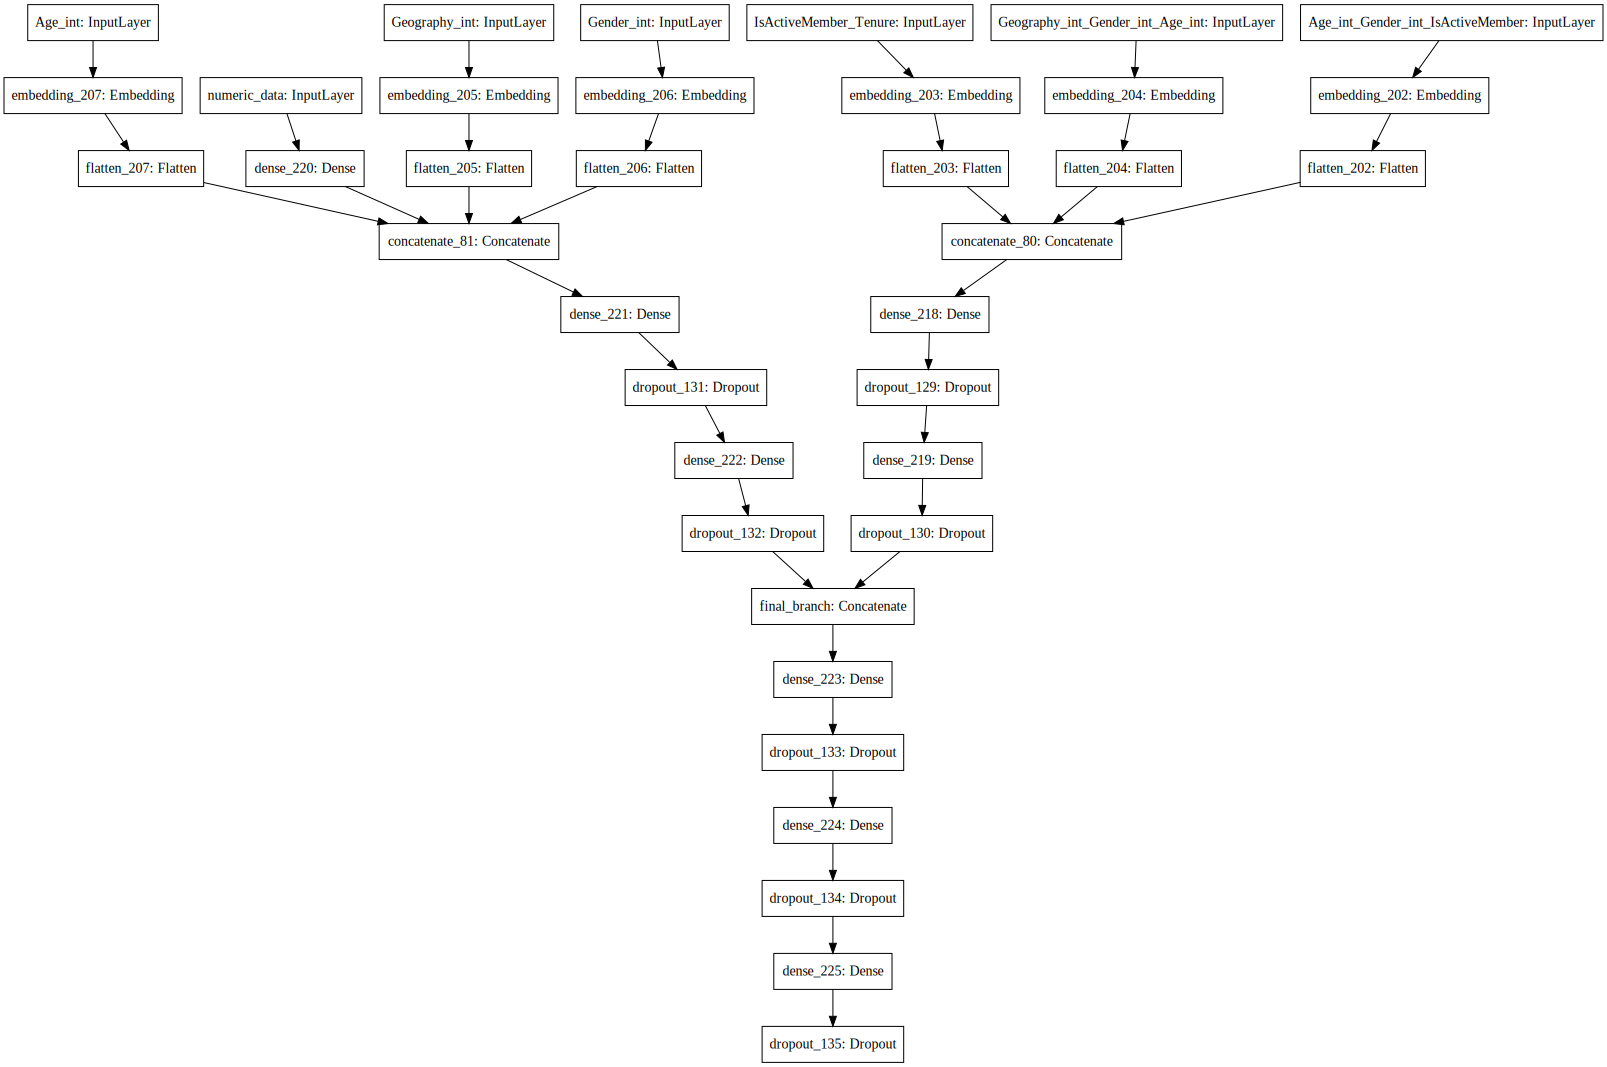

In [160]:

# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_branch_outputs = []

for cols in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(str(v) for v in x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(str(v) for v in x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_branch_outputs)
wide_branch = Dense(units=20, activation='relu')(wide_branch)
wide_branch = Dropout(rate=0.1)(wide_branch)
wide_branch = Dense(units=20, activation='relu')(wide_branch)
wide_branch = Dropout(rate=0.1)(wide_branch)

# reset this input branch
all_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False,name='numeric_data'))
x = Dense(units=20, activation='relu')(all_inputs[-1])
all_branch_outputs.append( x )

# merge the branches together
deep_branch = concatenate(all_branch_outputs)
deep_branch = Dense(units=50,activation='relu')(deep_branch)
deep_branch = Dropout(rate=0.1)(deep_branch)
deep_branch = Dense(units=10,activation='relu')(deep_branch)
deep_branch = Dropout(rate=0.1)(deep_branch)

final_branch = concatenate([wide_branch, deep_branch], name='final_branch')
final_branch = Dense(units=1,activation='sigmoid')(final_branch)
final_branch = Dropout(rate=0.1)(final_branch)
final_branch = Dense(units=1,activation='sigmoid')(final_branch)
final_branch = Dropout(rate=0.1)(final_branch)
final_branch = Dense(units=1,activation='sigmoid')(final_branch)
final_branch = Dropout(rate=0.1)(final_branch)

model2 = Model(inputs=all_inputs, outputs=final_branch)
SVG(model_to_dot(model2).create(prog='dot', format='svg'))

In [164]:
model2.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])

model2.fit(X_ints_train+ [X_train_num], y_train, epochs=10, batch_size=32, verbose=1)

yhat2 = model2.predict(X_ints_test + [X_test_num])
#print(mt.confusion_matrix(y_test,yhat2),mt.accuracy_score(y_test,yhat2))
print(yhat2)

Epoch 1/10
7754/7754 [==============================] - 4s 517us/step - loss: 0.2763 - acc: 0.4951
Epoch 2/10
7754/7754 [==============================] - 1s 103us/step - loss: 0.2757 - acc: 0.5006
Epoch 3/10
7754/7754 [==============================] - 1s 103us/step - loss: 0.2720 - acc: 0.5093
Epoch 4/10
7754/7754 [==============================] - 1s 103us/step - loss: 0.2768 - acc: 0.4929
Epoch 5/10
7754/7754 [==============================] - 1s 103us/step - loss: 0.2748 - acc: 0.5015
Epoch 6/10
7754/7754 [==============================] - 1s 110us/step - loss: 0.2771 - acc: 0.5006
Epoch 7/10
7754/7754 [==============================] - 1s 107us/step - loss: 0.2752 - acc: 0.5013
Epoch 8/10
7754/7754 [==============================] - 1s 102us/step - loss: 0.2765 - acc: 0.4947
Epoch 9/10
7754/7754 [==============================] - 1s 105us/step - loss: 0.2728 - acc: 0.4915
Epoch 10/10
7754/7754 [==============================] - 1s 112us/step - loss: 0.2734 - acc: 0.5026
[[0.44629

## Deep & Wide N/W 3

Here we have decided to concatinate each pair of cross categorical data with the generalized data layer just to see how this affects the performance & does the pair cross categorical data perform better with this or not.

## Step 1 - create generalized data layer

1. The numerical data are is passed through a single dense layer while the one-hot encoded features remains unchanged.
2. Bothe the layers are concatinated as it creates a generalized fitting model

## Step 2 - 1st cross category feature pair with generalized data layer

we directly concatinate the 1st cross categorical data pair layer with generalized data layer, so have the cross categorical data pair becomes more relavent.


## Step 3 - 2nd cross category feature pair with generalized data layer

we directly concatinate the 2nd cross categorical data pair layer with generalized data layer & this is also concatinated with the network built in step 2, SO that we get the benefits of both the pairs working together.

## Step 4 - 3rd cross category feature pair with generalized data layer

we now concatinate the 3rd cross categorical data pair layer with generalized data layer & this is also concatinated with the network built in step 3, SO that we get the benefits of all the pairs working together.

## Step 5 - Merge All

we concatinate all the layers created from above into 1 and pass it through a single dense layer followed by dropout.

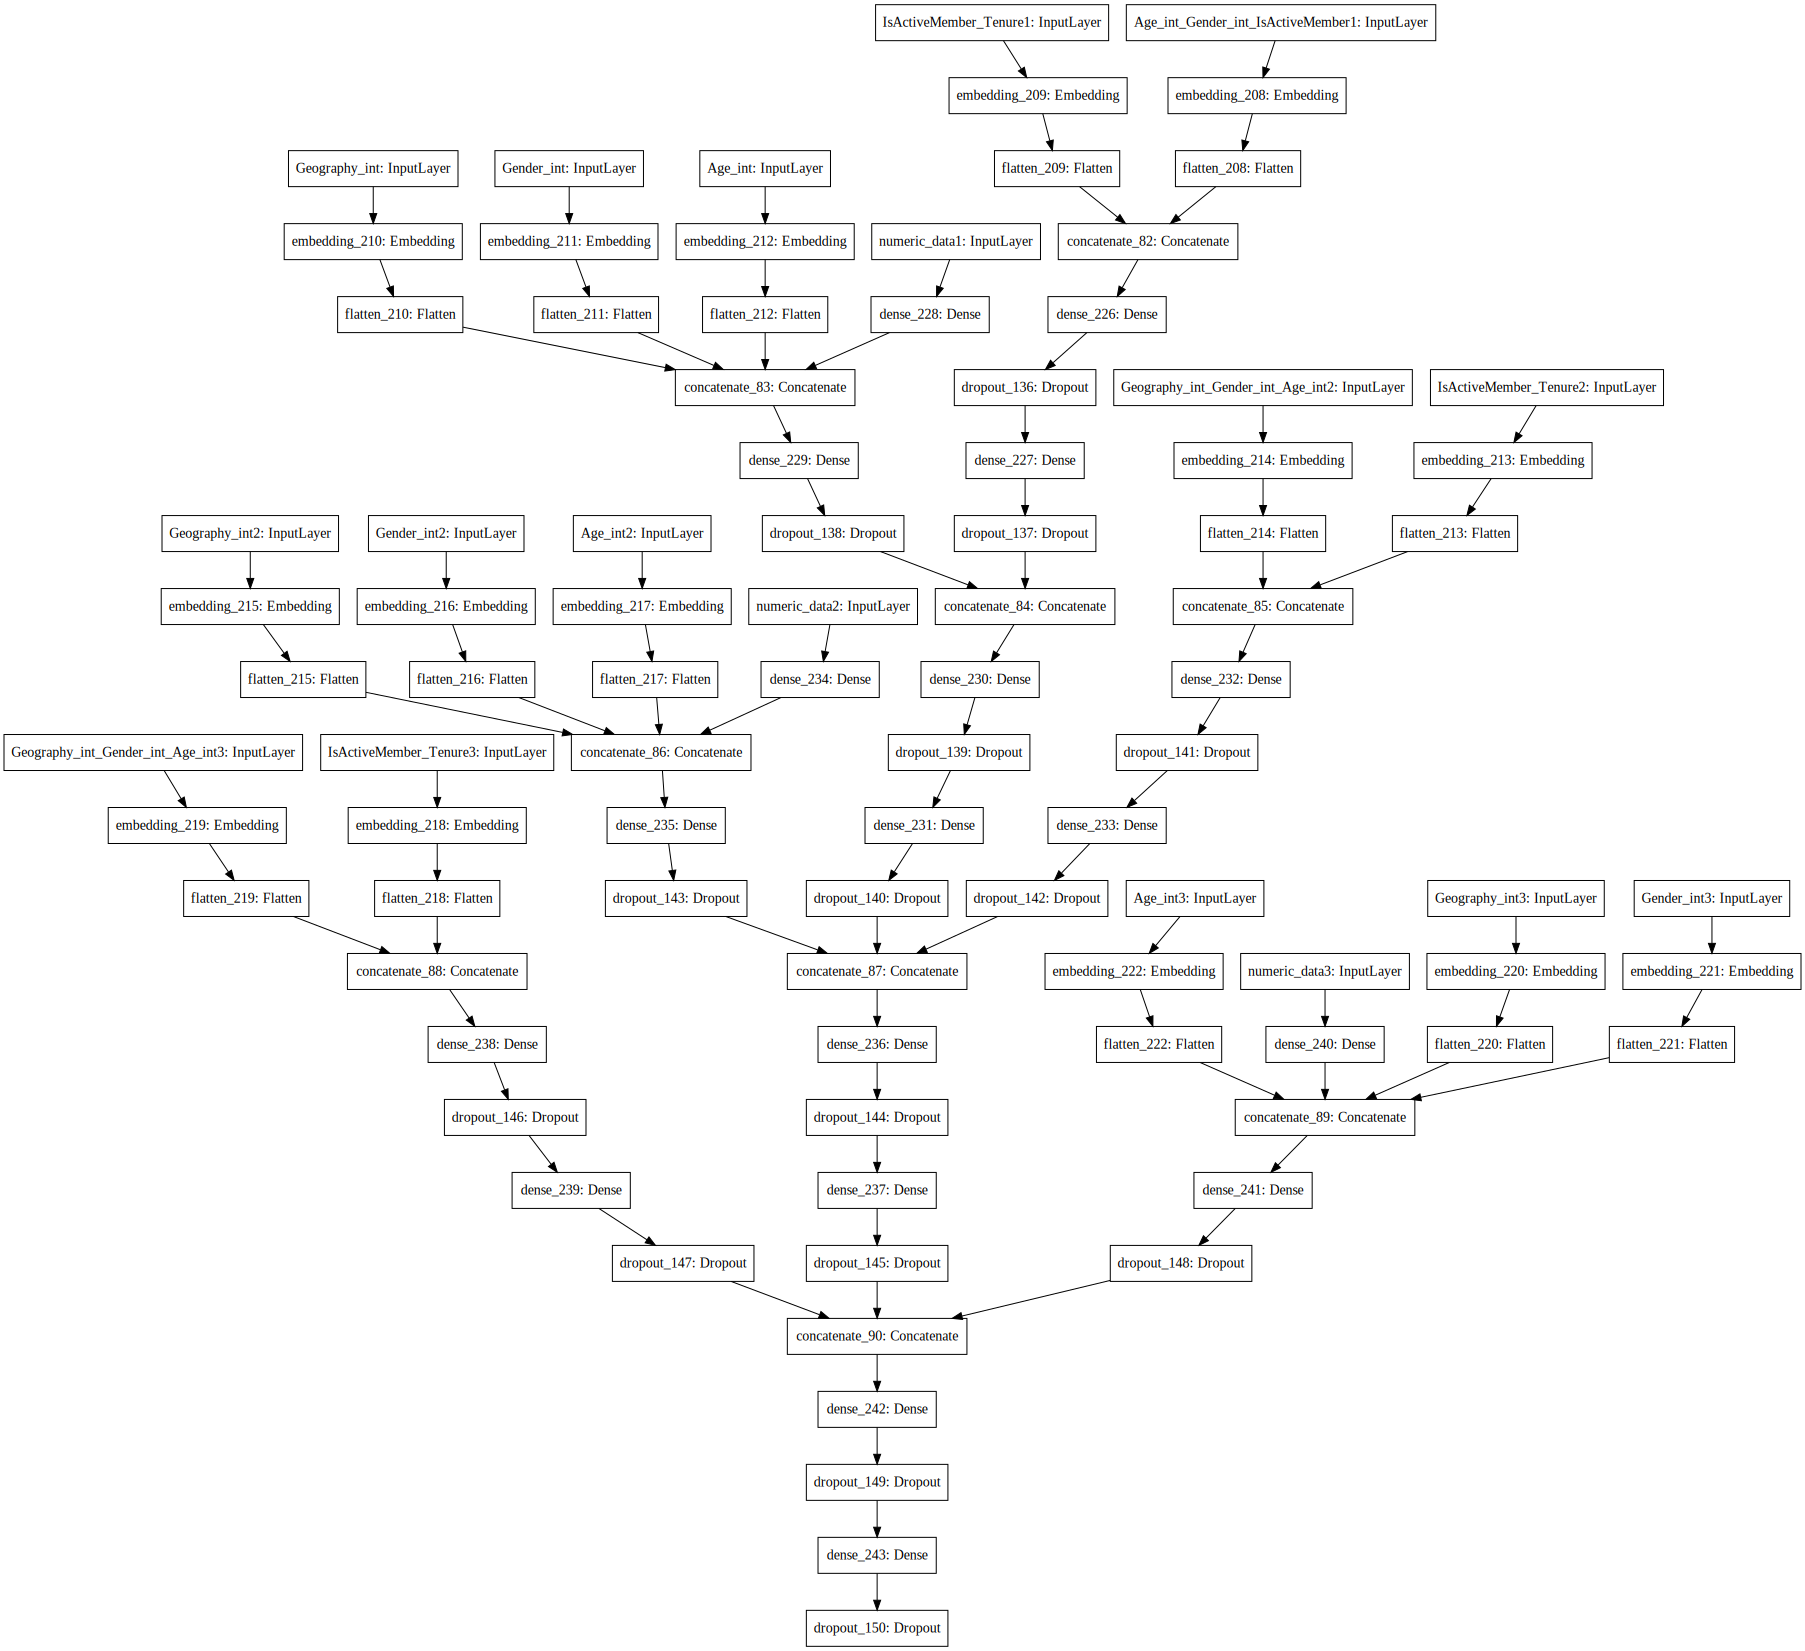

In [226]:
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_branch_outputs = []

enc = LabelEncoder()

#***** CP 12-1 ********

# create crossed labels
X_crossed_train = df_train[cross_columns[0]].apply(lambda x: '_'.join(str(v) for v in x), axis=1)
X_crossed_test = df_test[cross_columns[0]].apply(lambda x: '_'.join(str(v) for v in x), axis=1)

enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
X_crossed_train = enc.transform(X_crossed_train)
X_crossed_test = enc.transform(X_crossed_test)
X_ints_train.append( X_crossed_train )
X_ints_test.append( X_crossed_test )

# get the number of categories
N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
# create embedding branch from the number of categories
inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cross_columns[0]) + '1')
all_inputs.append(inputs)
x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
x = Flatten()(x)
all_branch_outputs.append(x)

#******************************
#***** CP 12-2 ********

# create crossed labels
X_crossed_train = df_train[cross_columns[1]].apply(lambda x: '_'.join(str(v) for v in x), axis=1)
X_crossed_test = df_test[cross_columns[1]].apply(lambda x: '_'.join(str(v) for v in x), axis=1)

enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
X_crossed_train = enc.transform(X_crossed_train)
X_crossed_test = enc.transform(X_crossed_test)
X_ints_train.append( X_crossed_train )
X_ints_test.append( X_crossed_test )

# get the number of categories
N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
# create embedding branch from the number of categories
inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cross_columns[1]) + '1')
all_inputs.append(inputs)
x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
x = Flatten()(x)
all_branch_outputs.append(x)

# merge the branches together
cp12_branch = concatenate(all_branch_outputs)
cp12_branch = Dense(units=20, activation='relu')(cp12_branch)
cp12_branch = Dropout(rate=0.1)(cp12_branch)
cp12_branch = Dense(units=20, activation='relu')(cp12_branch)
cp12_branch = Dropout(rate=0.1)(cp12_branch)

#******************************
#***** Deep 1 ********

all_branch_outputs = []

for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False,name='numeric_data1'))
x = Dense(units=20, activation='relu')(all_inputs[-1])
all_branch_outputs.append( x )

# merge the branches together
deep1_branch = concatenate(all_branch_outputs)
deep1_branch = Dense(units=50,activation='relu')(deep1_branch)
deep1_branch = Dropout(rate=0.1)(deep1_branch)

main_branch = concatenate([cp12_branch, deep1_branch])
main_branch = Dense(units=50,activation='relu')(main_branch)
main_branch = Dropout(rate=0.1)(main_branch)
main_branch = Dense(units=50,activation='relu')(main_branch)
main_branch = Dropout(rate=0.1)(main_branch)


#***** CP 13-1 ********
all_branch_outputs = []
# create crossed labels
X_crossed_train = df_train[cross_columns[1]].apply(lambda x: '_'.join(str(v) for v in x), axis=1)
X_crossed_test = df_test[cross_columns[1]].apply(lambda x: '_'.join(str(v) for v in x), axis=1)

enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
X_crossed_train = enc.transform(X_crossed_train)
X_crossed_test = enc.transform(X_crossed_test)
X_ints_train.append( X_crossed_train )
X_ints_test.append( X_crossed_test )

# get the number of categories
N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
# create embedding branch from the number of categories
inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cross_columns[1]) + '2')
all_inputs.append(inputs)
x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
x = Flatten()(x)
all_branch_outputs.append(x)

#******************************
#***** CP 13-3 ********

# create crossed labels
X_crossed_train = df_train[cross_columns[2]].apply(lambda x: '_'.join(str(v) for v in x), axis=1)
X_crossed_test = df_test[cross_columns[2]].apply(lambda x: '_'.join(str(v) for v in x), axis=1)

enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
X_crossed_train = enc.transform(X_crossed_train)
X_crossed_test = enc.transform(X_crossed_test)
X_ints_train.append( X_crossed_train )
X_ints_test.append( X_crossed_test )

# get the number of categories
N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
# create embedding branch from the number of categories
inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cross_columns[2]) + '2')
all_inputs.append(inputs)
x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
x = Flatten()(x)
all_branch_outputs.append(x)

# merge the branches together
cp13_branch = concatenate(all_branch_outputs)
cp13_branch = Dense(units=20, activation='relu')(cp13_branch)
cp13_branch = Dropout(rate=0.1)(cp13_branch)
cp13_branch = Dense(units=20, activation='relu')(cp13_branch)
cp13_branch = Dropout(rate=0.1)(cp13_branch)

#******************************
#***** Deep 2 ********

all_branch_outputs = []

for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col + '2')
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False,name='numeric_data2'))
x = Dense(units=20, activation='relu')(all_inputs[-1])
all_branch_outputs.append( x )

# merge the branches together
deep2_branch = concatenate(all_branch_outputs)
deep2_branch = Dense(units=50,activation='relu')(deep2_branch)
deep2_branch = Dropout(rate=0.1)(deep2_branch)

main_branch = concatenate([cp13_branch, deep2_branch, main_branch])
main_branch = Dense(units=50,activation='relu')(main_branch)
main_branch = Dropout(rate=0.1)(main_branch)
main_branch = Dense(units=50,activation='relu')(main_branch)
main_branch = Dropout(rate=0.1)(main_branch)


#***** CP 23-2 ********
all_branch_outputs = []
# create crossed labels
X_crossed_train = df_train[cross_columns[1]].apply(lambda x: '_'.join(str(v) for v in x), axis=1)
X_crossed_test = df_test[cross_columns[1]].apply(lambda x: '_'.join(str(v) for v in x), axis=1)

enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
X_crossed_train = enc.transform(X_crossed_train)
X_crossed_test = enc.transform(X_crossed_test)
X_ints_train.append( X_crossed_train )
X_ints_test.append( X_crossed_test )

# get the number of categories
N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
# create embedding branch from the number of categories
inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cross_columns[1]) + '3')
all_inputs.append(inputs)
x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
x = Flatten()(x)
all_branch_outputs.append(x)

#******************************
#***** CP 23-3 ********

# create crossed labels
X_crossed_train = df_train[cross_columns[2]].apply(lambda x: '_'.join(str(v) for v in x), axis=1)
X_crossed_test = df_test[cross_columns[2]].apply(lambda x: '_'.join(str(v) for v in x), axis=1)

enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
X_crossed_train = enc.transform(X_crossed_train)
X_crossed_test = enc.transform(X_crossed_test)
X_ints_train.append( X_crossed_train )
X_ints_test.append( X_crossed_test )

# get the number of categories
N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
# create embedding branch from the number of categories
inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cross_columns[2]) + '3')
all_inputs.append(inputs)
x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
x = Flatten()(x)
all_branch_outputs.append(x)

# merge the branches together
cp23_branch = concatenate(all_branch_outputs)
cp23_branch = Dense(units=20, activation='relu')(cp23_branch)
cp23_branch = Dropout(rate=0.1)(cp23_branch)
cp23_branch = Dense(units=20, activation='relu')(cp23_branch)
cp23_branch = Dropout(rate=0.1)(cp23_branch)

#******************************
#***** Deep 3 ********

all_branch_outputs = []

for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col + '3')
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False,name='numeric_data3'))
x = Dense(units=20, activation='relu')(all_inputs[-1])
all_branch_outputs.append( x )

# merge the branches together
deep3_branch = concatenate(all_branch_outputs)
deep3_branch = Dense(units=50,activation='relu')(deep3_branch)
deep3_branch = Dropout(rate=0.1)(deep3_branch)

main_branch = concatenate([cp23_branch, deep3_branch, main_branch])
main_branch = Dense(units=50,activation='relu')(main_branch)
main_branch = Dropout(rate=0.1)(main_branch)
main_branch = Dense(units=50,activation='relu')(main_branch)
main_branch = Dropout(rate=0.1)(main_branch)

model3 = Model(inputs=all_inputs, outputs=main_branch)
SVG(model_to_dot(model3).create(prog='dot', format='svg'))

In [138]:
model3.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])
class_weight = {0:0,1:80}
model3.fit(X_ints_test + [X_train_num] + [X_train_num] + [X_train_num], y_train, epochs=10, batch_size=32, verbose=1, class_weight=class_weight)

yhat3 = np.round(model3.predict(X_ints_test + [X_test_num] + X_ints_test + [X_test_num] + X_ints_test, y_test))
print(mt.confusion_matrix(y_test,yhat3),mt.accuracy_score(y_test,yhat3))

ValueError: Error when checking input: expected numeric_data1 to have shape (7,) but got array with shape (1,)

In [195]:
clf = MLPClassifier(hidden_layer_sizes=(100, ),
                    activation='logistic', 
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size='auto', # min of 200, num_samples
                    learning_rate='constant', 
                    learning_rate_init=0.789, # only SGD
                    power_t=0.5,    # only SGD
                    max_iter=255, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=True, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.5, # adam decay rate of moment
                    beta_2=0.66, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer


clf.fit(X_train,y_train)
yhatmlp = clf.predict(X_test)
print(mt.confusion_matrix(y_test,yhatmlp),mt.accuracy_score(y_test,yhatmlp))

[[949   0]
 [989   0]] 0.48968008255933954


In [229]:
def plot_embedding(x, y):
    cm = plt.cm.get_cmap('RdYlGn')
    f = plt.figure(figsize=(13, 13))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=y, cmap=cm)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    plt.show()
    
wts = model1.get_weights()
print(len(wts))

flat_list = []
for sublist in wts:
    for item in sublist:
        flat_list.append(item)
        
weights = np.asarray(flat_list)        
print(weights.shape)
# weights = weights.reshape(1, -1)
# print(weights.shape)

from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, verbose=1).fit_transform(wts[2])
transformed_weights = X_tsne.fit_transform(weights)

plot_embedding(transformed_weights, ['Exited', 'Not'])
# scatter(X_tsne[:, 0], X_tsne[:, 1], [0, 1])
# subplot(122)

16
(307,)
[t-SNE] Computing 1 nearest neighbors...
[t-SNE] Indexed 2 samples in 0.000s...
[t-SNE] Computed neighbors for 2 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 2 / 2
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 29.818880
[t-SNE] Error after 300 iterations: 0.000000


AttributeError: 'numpy.ndarray' object has no attribute 'fit_transform'

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.000s...
[t-SNE] Computed neighbors for 20 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.940655
[t-SNE] Error after 1000 iterations: 0.408943


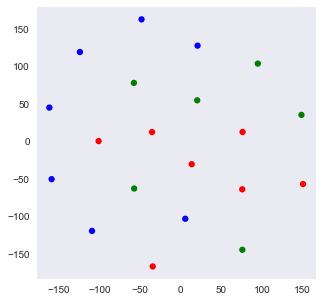

In [249]:

def plot_embedding(x, y):
    cm = plt.cm.get_cmap('RdYlGn')
    f = plt.figure(figsize=(5, 5))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=['Red', 'Blue', 'Green'], cmap=cm)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
#     ax.axis('off')
    ax.axis('tight')
    
    plt.show()

wts = model2.get_weights()
#print(len(wts))
weights = np.asarray(wts)
#weights = weights.reshape(1, 16)


from sklearn.manifold import TSNE

flat_list1 = []
for sublist in weights:
        flat_list1.append(sublist)
#print(flat_list1)



X_tsne = TSNE(n_components=2, verbose=1).fit_transform(weights[12])
#transformed_weights = X_tsne.fit_transform(weights)

plot_embedding(X_tsne, ['Exited', 'Not'])
# scatter(X_tsne[:, 0], X_tsne[:, 1], [0, 1])
# subplot(122)